In [1]:
import torch
import numpy as np
from drlqap.qap import GraphAssignmentProblem
from drlqap import dqn_nets, reinforce_nets, taskgenerators
from drlqap.simplesolver import solve_qap_backtracking
import matplotlib.pyplot as plt
import bokeh
from bokeh.plotting import figure, show, gridplot
from numpy.lib.stride_tricks import sliding_window_view
import drlqap.nn

In [2]:
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

# Setup

In [3]:
results = {}

In [15]:
import importlib
importlib.reload(dqn_nets)
importlib.reload(reinforce_nets)
importlib.reload(taskgenerators)
importlib.reload(drlqap.nn)

<module 'drlqap.nn' from '/media/windows/Users/Tim/Documents/Uni/thesis/repo/src/drlqap/nn.py'>

In [16]:
with open("../qapdata/testgraph.dat", "r") as f:
    qap = GraphAssignmentProblem.from_qaplib_string(f.read())

nets = {
    "dense_ln1_0": lambda: dqn_nets.dense(32, 1, 1, True, 'layer_norm'),
    "dense_ln1_1": lambda: dqn_nets.dense(32, 1, 1, True, 'layer_norm'),
    "dense_ln2_0": lambda: dqn_nets.dense(32, 0, 2, True, 'layer_norm'),
    "dense_ln2_1": lambda: dqn_nets.dense(32, 1, 2, True, 'layer_norm'),
    "dense_kmn1_0": lambda: dqn_nets.dense(32, 1, 1, True, 'keep_mean'),
    "dense_kmn1_1": lambda: dqn_nets.dense(32, 1, 1, True, 'keep_mean'),
    "dense_kmn2_0": lambda: dqn_nets.dense(32, 0, 2, True, 'keep_mean'),
    "dense_kmn2_1": lambda: dqn_nets.dense(32, 1, 2, True, 'keep_mean'),
    "dense_tmn1_0": lambda: dqn_nets.dense(32, 1, 1, True, 'transformed_mean'),
    "dense_tmn1_1": lambda: dqn_nets.dense(32, 1, 1, True, 'transformed_mean'),
    "dense_tmn2_0": lambda: dqn_nets.dense(32, 0, 2, True, 'transformed_mean'),
    "dense_tmn2_1": lambda: dqn_nets.dense(32, 1, 2, True, 'transformed_mean'),
    "dense_bn1_0": lambda: dqn_nets.dense(32, 1, 1, True, 'batch_norm'),
    "dense_bn1_1": lambda: dqn_nets.dense(32, 1, 1, True, 'batch_norm'),
    "dense_bn2_0": lambda: dqn_nets.dense(32, 0, 2, True, 'batch_norm'),
    "dense_bn2_1": lambda: dqn_nets.dense(32, 1, 2, True, 'batch_norm'),
    #"dense_ln2_2": lambda: dqn_nets.dense(32, 2, 2, True),
    #"dense_ln3_0": lambda: dqn_nets.dense(32, 0, 3, True),
    #"dense_ln3_1": lambda: dqn_nets.dense(32, 1, 3, True),
    #"dense_ln3_2": lambda: dqn_nets.dense(32, 2, 3, True),
    #"dense_1_0_no_ln": lambda: dqn_nets.dense(32, 0, 1, False, 'no_norm'),
    #"dense_1_1_no_ln": lambda: dqn_nets.dense(32, 1, 1, False, 'no_norm'),
    #"dense_2_0_no_ln": lambda: dqn_nets.dense(32, 0, 2, False, 'no_norm'),
    #"dense_3_0_no_ln": lambda: dqn_nets.dense(32, 0, 3, False, False),
    #"dense_1_0": lambda: dqn_nets.dense(32, 0, 1, False, 'layer_norm'),
    #"dense_1_1": lambda: dqn_nets.dense(32, 1, 1, False, 'layer_norm'),
    #"dense_2_0": lambda: dqn_nets.dense(32, 0, 2, False, 'layer_norm'),
    #"dense_3_0": lambda: dqn_nets.dense(32, 0, 3, False),
    
    #"mp_gat": lambda: dqn_nets.mp_gat(8, 8, 8, 3), 
    #"mp_gat_no_edge_nn": lambda: dqn_nets.mp_gat_no_edge_nn(32, 32, 32, 3), 
    #"mp_gat_no_edge_nn_undirected": lambda: dqn_nets.mp_gat_no_edge_nn_undirected(32, 32, 32, 3), 
    #"mp_gat_no_lp": lambda: dqn_nets.mp_gat_no_lp(32, 32, 32, 3), 
    "simple_link_prediction": lambda: dqn_nets.simple_link_prediction_undirected(32, 32, 3),
    #"mp_histogram_gat": lambda: dqn_nets.mp_histogram_gat(32, 32, 3),
}

# Target matrix

In [6]:
optimal_value, optimal_assignment = solve_qap_backtracking(qap)

In [7]:
optimal_assignment

[7, 6, 4, 0, 2, 3, 1, 5]

In [8]:
optimal_matrix = torch.eye(qap.size)[optimal_assignment]


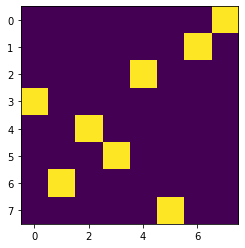

In [9]:
plt.imshow(optimal_matrix)

tensor(0.4203)


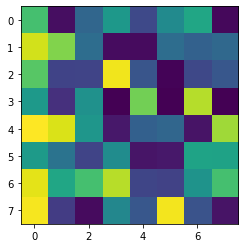

In [10]:
random_matrix = torch.rand((qap.size, qap.size))
print(random_matrix.mean())
plt.imshow(random_matrix)

# Initial output

In [11]:
def show_output(net):
    net_output = net(qap)
    plt.imshow(net_output.detach())

In [12]:
#show_output(nets["dense_ln"]())

# Train

In [13]:
def train(net, epochs, lr, weight_decay=0):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=weight_decay)   
    losses = []
    target = optimal_matrix
    for i in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        net_output = net(qap)
        loss = torch.nn.functional.mse_loss(net_output.flatten(), target.flatten())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [17]:
repetitions = 4
threshold = 0.03

def find_index_below(values, threshold):
    for i, x in enumerate(values):
        if x < threshold:
            return i
    return None

for name, net_constructor in nets.items():
    current_results = results[name] if name in results else []
    for i in range(len(current_results), repetitions):
        net = net_constructor()
        losses = train(net, 400, lr=1e-3)
        current_results.append((net, losses))

        threshold_steps = find_index_below(losses, threshold)
        print(f"{name} done; {threshold_steps} until {threshold}; final loss: {losses[-1]}")
    results[name] = current_results

print("done")

dense_bn1_0 done; 51 until 0.03; final loss: 1.3115126193952165e-06


KeyboardInterrupt: 


# Loss curves

In [18]:
from bokeh.palettes import Dark2_8
from bokeh.models import Range1d
import itertools

fig = figure()

def moving_average(x, n=3) :
    return np.mean(sliding_window_view(x, window_shape=n), axis=-1)

palette = Dark2_8
average = False
for i, (name, net_runs) in enumerate(results.items()):
    x = range(len(net_runs[0][1]))
    color = palette[i % len(palette)]
    
    if average:
        average_loss = np.mean([run[1] for run in net_runs], axis=0)
        fig.line(x=x, y=average_loss, legend_label=name, color=Dark2_5[i])
    else:
        for net, loss in net_runs:
            fig.line(x=x, y=loss, legend_label=name, color=color)

fig.y_range = Range1d(0,0.2)
fig.legend.click_policy = "hide"
show(fig)

# Outputs

In [ ]:
grid = []

for name, net_results in results.items():
    gridrow = []
    for net, losses in net_results:
        net_output = net(qap)
        data = dict(value=[net_output.detach().numpy()])
        fig = figure(
            title=name,
            tools="hover",
            tooltips=[("Value", "@value")]
        )
        fig.image(
            source=data, 
            image="value",
            x=0, y=0, 
            dw=qap.size, dh=qap.size, 
            palette="Viridis256"
        )
        gridrow.append(fig)
    grid.append(gridrow)
show(gridplot(grid, sizing_mode="scale_width"))